In [1]:
# using Revise
include("../src/StatReg.jl")
using .StatReg

In [2]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300));
# plot(x, phi.(x), title="Real phi function", label="Phi(x)")
# savefig("real_phi.png")

In [3]:
using QuadGK
kernel_name = "rectangular"
kernel(x::Real, y::Real) = getOpticsKernels(kernel_name)(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
# Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise;
# plot(y, f, title="$(kernel_name) kernel", label="f(y)", seriestype=:scatter, yerr=sig)
# savefig("integrated_$(kernel_name).png")

In [4]:
basis = CubicSplineBasis(y, "dirichlet");
# p = plot()
# for func in basis.basis_functions
#     p = plot!(x, func.(x), title="B-spline basis functions", legend=false, show = true)
# end
# display(p)
# savefig("basis.png")

In [7]:
Omega = omega(basis, 2)
using BAT

@time result = solve(
    basis,
    f,
    sig,
    kernel,
    y,
    BATSampling(nothing, MetropolisHastings(), 2, 1000),
#     AHMCSampling(nothing, 1, 1000000),
#     DHMCSampling(nothing, 1, 10000),
    Marginalize(),
    [Omega],
    PhiBounds(),
    );




┌ Info: Checking data
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:29
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:20
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/bases/utils.jl:32
┌ Info: Finding optimal alpha
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:35
┌ Info: Optimal alpha found
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:37
┌ Info: Starting solution
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/solve.jl:54
┌ Info: Starting sampling
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/bat.jl:33
┌ Info: Trying to generate 2 viable MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/WqhSP/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 2 MCMC chain(s).
└ @ BAT /Users/ta_nyan/.ju

636.346470 seconds (232.83 M allocations: 285.667 GiB, 8.25% gc time)
651.626306 seconds (679.90 M allocations: 296.952 GiB, 8.69% gc time)


┌ Info: Solved with BAT.jl
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/solvers/bat.jl:37


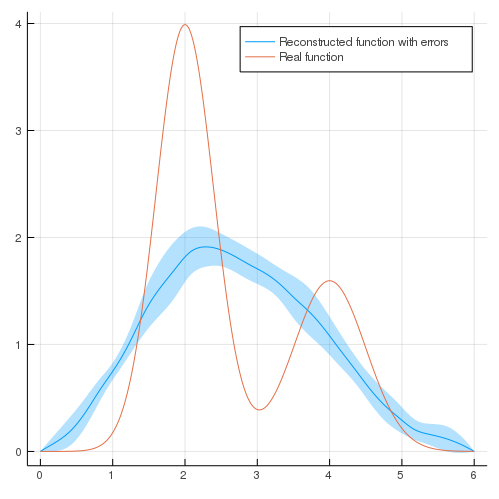

In [8]:
phi_reconstructed = result.solution_function.(x)
phi_reconstructed_errors = result.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")
# # savefig("reconstructed.png")